In [1]:
#Load libraries, model definition and helper functions
#The example 1 is "Lake Sliv" (Slivsø) and example 2 is "Lake Fuglsang" (Fuglsangsø) which was not part of the data used in the paper

import torch #Deep learning library
import rasterio as rio #Geographic raster handling
from matplotlib import pyplot as plt #Plotting
from model import UNet #Model definition
import numpy as np #Grid/array manipulation

In [2]:
#Path to best model weights
best_model = "model_weights/lake_models_buffer_100_weights_dem_32_epoch=337-step=4055.pt"

#Path to example lake and mask in ".tif" raster format
lake_1_path = "examples/example_lake_1.tif"
mask_1_path = "examples/example_mask_1.tif"

lake_2_path = "examples/example_lake_2.tif"
mask_2_path = "examples/example_mask_2.tif"

In [3]:
#Initilise model with weights
state_dict = torch.load(best_model, map_location=torch.device('cpu'))

unet = UNet(in_channels=1, out_channels=1, mask_channels=1, init_features=32)
unet.load_state_dict(state_dict)

<All keys matched successfully>

In [4]:
#Read lake and mask rasters with rasterio
with rio.open(lake_2_path, 'r') as src:
    lake = src.read(1)
    lake[lake == -9999] = 0 #Replace raster nodata value (-9999) with 0
    profile = src.profile
    
with rio.open(mask_2_path, 'r') as src:
    mask = src.read(1)
    mask[mask == -9999] = 0 #Replace raster nodata value (-9999) with 0

In [5]:
#Define function for plotting
def plot_grid(img):
    fig, ax = plt.subplots()
  
    shw = ax.imshow(img)

    bar = plt.colorbar(shw)

    plt.xlabel('X')
    plt.ylabel('Y')
    bar.set_label('Elevation (m)')
    plt.show()

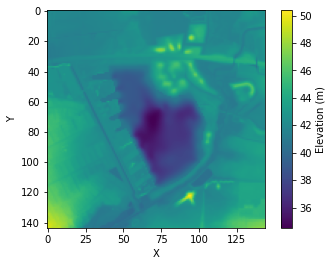

In [6]:
#Plot dem and lake bathymetry
plot_grid(lake)

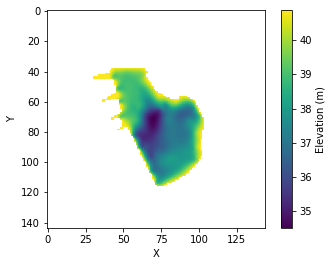

In [7]:
#Plot lake bathymetry
lake_mask = lake * mask

#Create copy for plotting and replace zeros with NA
lake_mask_na = lake_mask.copy()
lake_mask_na[lake_mask == 0] = np.nan

#Plot observed lake bathymetry (bottom elevation)
plot_grid(lake_mask_na)

In [8]:
#Model inputs should be divisible by 16 due to model architecture
#(then grid input and output dimensions are the same)
print(lake.shape)
print(lake.shape[0] % 16)


(144, 144)
0


In [10]:
#Define utility functions for pre-preprocessing and prediction

#Scale data range to -1 to 1
#Min-max values are min-max elevations for Denmark
def dem_scale(dem, min_val=-25, max_val=175):
    zero_one = (dem - min_val)/(max_val - min_val)
    minus_one = (zero_one*2)-1
    
    return(minus_one)

#Scale range back to original (from -1 to 1)
def dem_inv_scale(dem_scale, min_val=-25, max_val=175):
    zero_one = (dem_scale + 1)/2
    orig_scale = zero_one*(max_val - min_val) + min_val
    
    return(orig_scale)

#Function for prediction of lake bathymetry
def predict_unet(dem, mask, model):
    
    scaled = dem_scale(dem)
    
    target_tensor = torch.from_numpy(scaled).unsqueeze(0)
    mask_tensor = torch.from_numpy(mask).unsqueeze(0)

    input_tensor = target_tensor * (1-mask_tensor)

    model.eval()
    with torch.no_grad():
        xhat_tensor = model(input_tensor.unsqueeze(0), mask_tensor.unsqueeze(0))
        
    xhat_np = xhat_tensor.squeeze().numpy()
    xhat_np_orig_scale = dem_inv_scale(xhat_np)
    
    return(xhat_np_orig_scale)

In [11]:
#Perform prediction
predicted = predict_unet(lake, mask, unet)
            

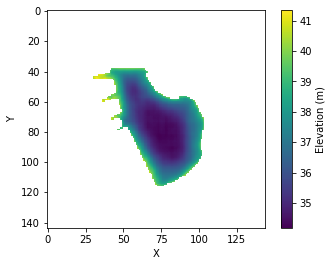

In [13]:
#Plot predicted lake bathymetry
predicted_mask = predicted*mask

#Create copy for plotting and replace zeros with NA
predicted_mask_na = predicted_mask.copy()
predicted_mask_na[lake_mask == 0] = np.nan

#Plot predicted lake bathymetry (bottom elevation)
plot_grid(predicted_mask_na)

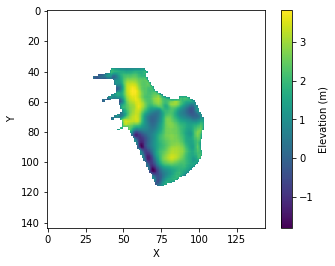

In [15]:
#Calculate difference
obs_pred_diff = lake_mask_na - predicted_mask_na

#Plot difference between observed and predicted lake bathymetry (bottom elevation)
plot_grid(obs_pred_diff)

In [16]:
#Replace non-lake cells with nodata value
predicted_mask[lake_mask == 0] = -9999

predicted_path = "examples/example_predicted.tif"

#Write predicted raster to file
with rio.open(predicted_path, 'w', **profile) as dst:
    dst.write(predicted_mask, 1)
